
# Machine Learning  Engineer Nanodegree Capstone
Image classification of common grocery items and produce <br>

OS: Windows `10` <br>
Language: Python `3.7.3` <br>
Libraries: Pytorch `0.4.1`, matplotlib `3.1.1`, NumPy `1.16.4`, imgaug `0.3.0` <br>
Framework: Jupyter Notebook <br>

## Outline
- use `imaug` library to augment images to increase dataset size
- merge data from two existing datasets, one containing 81 classes of produce and one containing 25 of grocery items
- use PyTorch to transform, preprocess, train and test data
- compare ResNet18 to benchmark model ResNet50
- between ResNet50 and ResNet18, the model with the highest accuracy was ResNet18


## Datasets 

[Freiberg Grocery Dataset](http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/) <br>
[Fruits 360 Dataset](https://data.mendeley.com/datasets/rp73yg93n8/1) <br>


In [1]:
import os, shutil
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import copy
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
%matplotlib inline
plt.ion 
import torchvision
from torchvision import datasets, models, transforms 
import torch
import torch.nn as nn
import PIL
from collections import OrderedDict
from PIL import Image
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data.dataset import Dataset
from torchvision import utils
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler as lr_scheduler
import torchvision.datasets as datasets
from torchvision.transforms import ToPILImage
from torch.autograd import Variable
import torch.nn.functional as F

### Organizing Datasets ###
For this project, the datasets were downloaded and saved in the same path: `C:\\Users\\User\\Documents\\Dataset`. <br>
Both datasets are organized with folders of each class, and images inside each folder.  However, the Freiberg Grocery dataset does not have the images divided into a train and test set.  A train and test folder along with folders for each class is created, and images are divided [into train images and test images.](https://forums.fast.ai/t/i-developed-a-python-package-to-spit-folders-train-val-test/24335/3)   

In [2]:
sets = 'C:\\Users\\User\\Documents\\Dataset\\freiburg_groceries_dataset\\sets'
os.mkdir(sets)

classes = ('BEANS', 'CAKE', 'CANDY', 'CEREAL', 'CHIPS', 'CHOCOLATE',
           'COFFEE', 'CORN', 'FISH', 'FLOUR', 'HONEY', 'JAM', 'JUICE',
           'MILK', 'NUTS', 'OIL', 'PASTA', 'RICE', 'SODA', 'SPICES',
           'SUGAR', 'TEA', 'TOMATO_SAUCE', 'VINEGAR', 'WATER')

OUTPATH = 'C:\\Users\\User\\Documents\\Dataset\\freiburg_groceries_dataset\\sets'
INPATH = 'C:\\Users\\User\\Documents\\Dataset\\freiburg_groceries_dataset\\images'

#Create train and test folders,
#with folders for each class

for x in classes:
    os.makedirs(OUTPATH+'\\train\\'+x, exist_ok=True)
    os.makedirs(OUTPATH+'\\test\\'+x, exist_ok=True)
    files = os.listdir(INPATH + '\\' + x)


#Move images from original folder
#to new train and test folders,
#put 20% in test folder and 80% in train folder

counts = {x:0 for x in classes}

for x in classes:
    filenames = os.listdir(INPATH + '\\' + x)
    testset = len(filenames) * 0.2 
    for fl in filenames:
        for cl in classes:
            if cl in fl:
                counts[cl] += 1 # increase count +1
                if counts[cl] < testset:
                    shutil.move(INPATH + '\\' + cl + '\\' + fl, OUTPATH + '\\test\\'+ cl + '\\' + fl)
                else:
                    shutil.move(INPATH + '\\' + cl + '\\' + fl, OUTPATH + '\\train\\' + cl + '\\' + fl)

### Augmenting Data ###
The two dataset sizes are uneven. The Freiberg Grocery dataset contains approximately 80 - 150 images per class, whereas the Fruits 360 dataset contains 400+ images per class.  Having uneven dataset sizes between classes means that the algorithm will not learn smaller class sizes, and it will cause incorrect calculations for the metric used, the classification accuracy metric.  The library `imgaug` was used to create new, augmented images from existing images.  Source for [imgaug here.](https://github.com/aleju/imgaug)

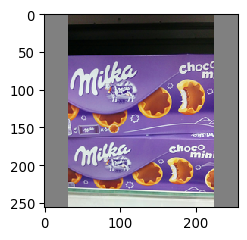

Augmented:


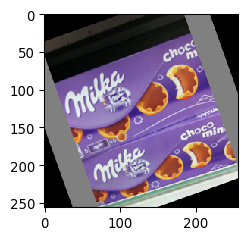

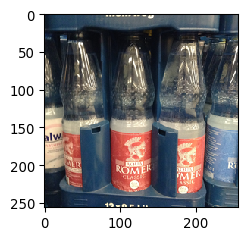

Augmented:


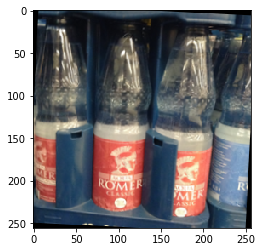

In [3]:
#example of rotation with one image:

image = imageio.imread('C:\\Users\\User\\Documents\\Dataset\\freiburg_groceries_dataset\\sets\\train\\CHOCOLATE\\CHOCOLATE0078.png')

ia.imshow(image)

ia.seed(6)

rotate = iaa.Affine(rotate=(-25, 25))
image_aug = rotate.augment_image(image)

print("Augmented:")
ia.imshow(image_aug)

#example of rotation, crop, and flip with one image:

nimg = imageio.imread('C:\\Users\\User\\Documents\\Dataset\\freiburg_groceries_dataset\\sets\\train\\WATER\\WATER0082.png')

ia.imshow(nimg)

ia.seed(3)

seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Affine(rotate=(-25, 25))
], random_order=True)

nimg_aug = seq.augment_image(nimg)

print("Augmented:")
plt.imshow(nimg_aug)

In [4]:
'''https://github.com/aleju/imgaug/issues/258'''

path = 'C:\\Users\\User\\Documents\\Dataset\\freiburg_groceries_dataset\\sets\\train'

#Crop, flip left to right, and rotate images randomly

ia.seed(2)

seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.1)),
    iaa.Affine(rotate=(-25,25))
], random_order=True)

#Iterate through train folder in
#Freiberg Grocery dataset, and create
#new augmented images 

for folder in os.listdir(path):
    i = 0
    for fname in os.listdir(path + '\\' + folder):
        img = imageio.imread(path + '\\' + folder + '\\' + fname)
        #ia.imshow(img)
        img_aug = seq.augment_image(img)
        #ia.imshow(img_aug)
        
        imageio.imwrite(os.path.join(path, path + '\\' + folder + '\\' + folder + "%06d.png" % (i,)), img_aug)
        i += 1

for folder in os.listdir(path):
    print('Number of images in {} class:'.format(folder), len(os.listdir(path + '\\'  + folder)))


Number of images in BEANS class: 218
Number of images in CAKE class: 258
Number of images in CANDY class: 596
Number of images in CEREAL class: 446
Number of images in CHIPS class: 290
Number of images in CHOCOLATE class: 492
Number of images in COFFEE class: 478
Number of images in CORN class: 156
Number of images in FISH class: 178
Number of images in FLOUR class: 176
Number of images in HONEY class: 298
Number of images in JAM class: 386
Number of images in JUICE class: 484
Number of images in MILK class: 260
Number of images in NUTS class: 270
Number of images in OIL class: 230
Number of images in PASTA class: 276
Number of images in RICE class: 242
Number of images in SODA class: 284
Number of images in SPICES class: 332
Number of images in SUGAR class: 190
Number of images in TEA class: 454
Number of images in TOMATO_SAUCE class: 274
Number of images in VINEGAR class: 252
Number of images in WATER class: 420


It looks like some classes still contain substantially less images than others, so another augmentation iteration is done to increase the size of these specific classes:

In [5]:
path = 'C:\\Users\\User\\Documents\\Dataset\\freiburg_groceries_dataset\\sets\\train'

classes = ('BEANS', 'CAKE', 'CHIPS', 'CORN', 'FISH', 'FLOUR', 
          'HONEY', 'MILK', 'NUTS', 'OIL', 'PASTA', 'RICE',
          'SODA', 'SUGAR', 'TOMATO_SAUCE', 'VINEGAR')
#Crop, flip left to right, and rotate images randomly

ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.2)),
    iaa.Affine(rotate=(-10,10))
], random_order=True)

#Iterate through train folder in
#Freiberg Grocery dataset, and create
#new augmented images 

for x in classes:
    for folder in os.listdir(path):
        i = 0
        if x in folder:
            for fname in os.listdir(path + '\\' + folder):
                img = imageio.imread(path + '\\' + folder + '\\' + fname)
                #ia.imshow(img)
                img_aug = seq.augment_image(img)
                #ia.imshow(img_aug)

                imageio.imwrite(os.path.join(path, path + '\\' + folder + '\\' + folder + "%06d" % (i,) + "%06d.png" % (i,)), img_aug)
                i += 1

for folder in os.listdir(path):
    print('Number of images in {} class:'.format(folder), len(os.listdir(path + '\\'  + folder)))

Number of images in BEANS class: 436
Number of images in CAKE class: 516
Number of images in CANDY class: 596
Number of images in CEREAL class: 446
Number of images in CHIPS class: 580
Number of images in CHOCOLATE class: 492
Number of images in COFFEE class: 478
Number of images in CORN class: 312
Number of images in FISH class: 356
Number of images in FLOUR class: 352
Number of images in HONEY class: 596
Number of images in JAM class: 386
Number of images in JUICE class: 484
Number of images in MILK class: 520
Number of images in NUTS class: 540
Number of images in OIL class: 460
Number of images in PASTA class: 552
Number of images in RICE class: 484
Number of images in SODA class: 568
Number of images in SPICES class: 332
Number of images in SUGAR class: 380
Number of images in TEA class: 454
Number of images in TOMATO_SAUCE class: 548
Number of images in VINEGAR class: 504
Number of images in WATER class: 420


### Merging Datasets ###
Now that the Freiberg Grocery dataset is organized into test and training folders, and images were augmented and added to the training foler, the two datasets can be merged.  The images from the train folders for the Freiberg and Fruits 360 dataset are moved to one train folder, and the images from the test folders are moved to one test folder.  Then, the folder names are reformatted to `class_name` and the images are reformatted to `class_name_#` with `#` being the image number.

In [6]:
#Combine the Freiberg and Fruits 360 datasets into one training set 

train_set = 'C:\\Users\\User\\Documents\\Dataset\\train'
os.mkdir(train_set)
freiberg_train_set = 'C:\\Users\\User\\Documents\\Dataset\\freiburg_groceries_dataset\\sets\\train'
fruits_train_set = 'C:\\Users\\User\\Documents\\Dataset\\fruits-360_dataset\\fruits-360\\Training'

for folder in os.listdir(freiberg_train_set):
    #print(folder)
    src = os.path.join(freiberg_train_set, folder)
    dst = train_set
    shutil.move(src, dst)
    
for folder in os.listdir(fruits_train_set):
    #print(folder)
    src = os.path.join(fruits_train_set, folder)
    dst = train_set
    shutil.move(src, dst)

In [7]:
#Combine both datasets into one test set

test_set = 'C:\\Users\\User\\Documents\\Dataset\\test'
os.mkdir(test_set)
freiberg_test_set = 'C:\\Users\\User\\Documents\\Dataset\\freiburg_groceries_dataset\\sets\\test'
fruits_test_set = 'C:\\Users\\User\\Documents\\Dataset\\fruits-360_dataset\\fruits-360\\Test'


for folder in os.listdir(freiberg_test_set):
    src = os.path.join(freiberg_test_set, folder)
    dst = test_set
    shutil.move(src, dst)

for folder in os.listdir(fruits_test_set):
    src = os.path.join(fruits_test_set, folder)
    dst = test_set
    shutil.move(src, dst)

In [8]:
#rename folders for training set

os.chdir(train_set)
for folder in os.listdir(train_set):
    #print(folder)
    os.rename(folder, folder.replace(' ', '_').lower())
    #print(folder)
    
#rename images to format "class_#.png"

for folder in os.listdir(train_set):
    i = 1
    folder_path = os.path.join(train_set, folder)
    try:
        for img in os.listdir(folder_path):
            abs_path = os.path.join(folder, img)
            new_name = os.path.join(folder, folder + "_" + str(i) + '.png')
            os.rename(abs_path, new_name)
            i += 1
    except:
        pass

In [9]:
#rename folders for test set

os.chdir(test_set)
for folder in os.listdir(test_set):
    #print(folder)
    os.rename(folder, folder.replace(' ', '_').lower())
    #print(folder)

#rename images to format "class_#.png"

for folder in os.listdir(test_set):
    i = 1
    folder_path = os.path.join(test_set, folder)
    try:
        for img in os.listdir(folder_path):
            abs_path = os.path.join(folder, img)
            new_name = os.path.join(folder, folder + '_' + str(i) + '.png')
            os.rename(abs_path, new_name)
            i += 1
    except:
        pass

In [10]:
#check results of reformatted data 

#folder = os.listdir(train_set)
#for f in folder:
#    print('\nfolder name: ', f)
#    for img in os.listdir(f):
#        print('image: ', img) 

### Overwriting the `Dataset class` for a Custom Dataset ###
Creating a custom dataset in PyTorch is possible by overriding the `__init___`, `__len__`, and `__getitem__` subclass functions of the `Dataset class` in PyTorch.
The `__init__` function is used for data preparation, transformation, reading files and images, and setting up data to be read by index.  The `__getitem__` function is used to return data and labels, apply initiated transformations, set up GPU, and return data as tensors.  The `__len__` function returns the number of data points in the new dataset.  


In [11]:
#Since this is a custom dataset,
#__getitem__ and __len__ in the Dataset class
#need to be overwritten.

__all__ = ['GroceryDataset']


class GroceryDataset(Dataset):
    
    def __init__(self, root, transform=None, target_transform=None):
        class_list = os.listdir(root)
        class_list.sort()
        #print(class_list)
        
        
        label_mapping = {k: v for v, k in enumerate(class_list)}
        
        imgs = []
        
        for f in class_list:
            for img in os.listdir(f):
                img = os.path.join(root, f, img)
                label = label_mapping[f]
                imgs.append((img, label))
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        
        
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = PIL.Image.open(fn).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.transform(label)
        return img, label
    
    def __len__(self):
        return len(self.imgs)        


### Transforming Images ###
The images need to be altered into having shared characteristics that are compatible with the type of algorithm that will be used to process them.  Training images are resized, cropped, and randomly augmented for variance. Test images are not augmented, just resized and cropped to standardize size. <br> <br>
**Train images:**
- Resize: resized all images to 224 pixels.  224 is the standard size used for ResNet models.
- RandomRotation: some images were randomly flipped 90 degrees.
- RandomResizedCrop: some images were randomly cropped, so that there was more variance among the images.
- RandomHorizontalFlip: some images were randomly flipped, which gives more variance among images and potentially prevents overfitting. <br><br>

**Test images:**
- Resize: Images were resized to 224, same as train images.
- CenterCrop: Images were cropped to 224.


In [12]:
#The data needs to be transformed and run through DataLoader


if __name__ == '__main__':
    

    
    train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomRotation(90),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])
    
    test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])
    
    
    
    train_data = GroceryDataset(root=train_set, transform=train_transform)
    train_data_loader = data.DataLoader(train_data, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)   

    classes = os.listdir(train_set)
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    print('\nclass to index: ', class_to_idx)
    print('\n number of classes: ', len(class_to_idx))
    print('\nnumber of train images: ', len(train_data))
    for step, (tx, ty) in enumerate(train_data_loader, 0):
        print('---train_set_tensors---', tx.shape, ty)
    
    
    test_data = GroceryDataset(root=test_set, transform=test_transform)
    test_data_loader = data.DataLoader(test_data, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
    
    for step, (tx, ty) in enumerate(test_data_loader, 0):
        print('---test_set_tensors---', tx.shape, ty)

dataloaders = {
    "train": train_data_loader,
    "test": test_data_loader
}



class to index:  {'apple_braeburn': 0, 'apple_golden_1': 1, 'apple_golden_2': 2, 'apple_golden_3': 3, 'apple_granny_smith': 4, 'apple_red_1': 5, 'apple_red_2': 6, 'apple_red_3': 7, 'apple_red_delicious': 8, 'apple_red_yellow': 9, 'apricot': 10, 'avocado': 11, 'avocado_ripe': 12, 'banana': 13, 'banana_red': 14, 'beans': 15, 'cactus_fruit': 16, 'cake': 17, 'candy': 18, 'cantaloupe_1': 19, 'cantaloupe_2': 20, 'carambula': 21, 'cereal': 22, 'cherry_1': 23, 'cherry_2': 24, 'cherry_rainier': 25, 'cherry_wax_black': 26, 'cherry_wax_red': 27, 'cherry_wax_yellow': 28, 'chips': 29, 'chocolate': 30, 'clementine': 31, 'cocos': 32, 'coffee': 33, 'corn': 34, 'dates': 35, 'fish': 36, 'flour': 37, 'granadilla': 38, 'grapefruit_pink': 39, 'grapefruit_white': 40, 'grape_pink': 41, 'grape_white': 42, 'grape_white_2': 43, 'guava': 44, 'honey': 45, 'huckleberry': 46, 'jam': 47, 'juice': 48, 'kaki': 49, 'kiwi': 50, 'kumquats': 51, 'lemon': 52, 'lemon_meyer': 53, 'limes': 54, 'lychee': 55, 'mandarine': 56, 

Display the transformed [images using a helper function created by Udacity.](https://github.com/udacity/DL_PyTorch/blob/master/helper.py#L42)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


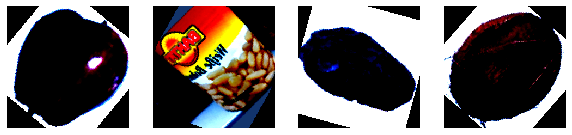

In [13]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


data_iter = iter(dataloaders['train'])

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)

for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=False)

In [14]:
#check if GPU is available
#and switch to GPU if it is

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()

if not use_gpu:
    print('Deferring to CPU... ')
else:
    print('Using GPU for training... ')

Deferring to CPU... 


### Set up the Pre-Trained Network ###
The benefit of using a pre-trained network such as ResNet is that the weights and parameters have already been initialized and trained on a different dataset.  Since the model is pre-trained, it has already learned certain patterns from the previous dataset, making feature extraction more efficient for the new dataset.  This method of training is called transfer learning, because features detected from the previous training session can be transferred to new images.  
When using a pre-trained model, there is the option to freeze all, or particular layers, meaning that the parameters that are frozen remain fixed.


In [15]:
#Freeze weights in final layer and create new architecture 

#load resnet model
model = torchvision.models.resnet50(pretrained=True) 

#freeze final layer
for param in model.parameters():
    param.requires_grad = False

inputs = model.fc.in_features
output = 106

#create layer
model.fc = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(inputs, 1024)),
                      ('relu1', nn.ReLU()),
                      ('dropout1', nn.Dropout(p=0.1)),
                      ('fc2', nn.Linear(1024, 256)),
                      ('relu2', nn.ReLU()),
                      ('dropout2', nn.Dropout(p=0.1)),
                      ('fc3', nn.Linear(256, output)),
                      ('output', nn.LogSoftmax(dim=1))]))


### Hyperparamters ###
- The optimizer Adam (an abbreviation of adaptive moment estimation) was created specifically for deep learning tasks.  The Adam algorithm determines learning rates for different parameters by using estimations of the first and second moments of gradient for each weight in the neural network.  
- Cross-entropy loss is a loss function commonly used for classification tasks.  Cross entropy gives greater loss to wrong predictions, particularly if they are done in higher confidence, meaning that an additional weight is placed on the confidence of each incorrect prediction.
- The learning rate scheduler uses step decay to prevent the parameter vector from having too high of kinetic energy, and overshooting the local minima, or from having too low of kinetic energy, and settling in a false minima.


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) 
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Train and Test Model ###
Using the pre-trained model ResNet and the hyperparameters discussed above, the model is trained for 15 epochs.  Output for training prints every 5 batches and shows the epoch number and the training loss associated with each batch.  Output for accuracy shows the model's overall accuracy for all classes combined, as well as a breakdown of accuracy per class.

In [17]:
#Train model on 15 epochs, print training loss
#print every 5 batches

epochs = 15

for epoch in range(epochs):  

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
        if i % 5 == 4:    
            print('[%d, %5d] Training loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0


print('Finished Training')

[1,     5] Training loss: 15.109
[1,    10] Training loss: 5.095
[1,    15] Training loss: 4.890
[1,    20] Training loss: 4.971
[1,    25] Training loss: 4.892
[1,    30] Training loss: 4.995
[1,    35] Training loss: 5.085
[1,    40] Training loss: 5.099
[1,    45] Training loss: 4.941
[1,    50] Training loss: 4.925
[1,    55] Training loss: 4.928
[1,    60] Training loss: 4.971
[1,    65] Training loss: 5.261
[1,    70] Training loss: 4.980
[1,    75] Training loss: 4.891
[1,    80] Training loss: 4.695
[1,    85] Training loss: 4.955
[1,    90] Training loss: 5.269
[1,    95] Training loss: 5.058
[1,   100] Training loss: 4.921
[1,   105] Training loss: 4.994
[1,   110] Training loss: 5.215
[1,   115] Training loss: 5.168
[1,   120] Training loss: 4.769
[1,   125] Training loss: 4.805
[1,   130] Training loss: 4.736
[1,   135] Training loss: 4.852
[1,   140] Training loss: 4.931
[1,   145] Training loss: 5.020
[1,   150] Training loss: 4.863
[1,   155] Training loss: 5.297
[1,   1

Actual class of each image:  tomato_4 tangelo mandarine avocado huckleberry banana  plum cactus_fruit
Predicted class:  tomato_1 tomato_1 pineapple_mini grapefruit_white grapefruit_white pineapple_mini tomato_1 pineapple_mini


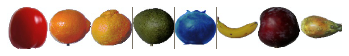

In [18]:
#Print the actual class of 8 different images
#compared to the predicted class from the test set 

dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('Actual class of each image: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

logps = model(images)

_, predicted = torch.max(logps, 1)

print('Predicted class: ', ' '.join('%5s' % classes[predicted[j]] for j in range(8)))

In [19]:
#Overall accuracy of test images

correct = 0
total = 0

with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        logps = model(images)
        _, predicted = torch.max(logps.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
      
        
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 1 %


In [20]:
'''https://stackoverflow.com/questions/41488279/neural-network-always-predicts-the-same-class'''

#Display accuracy for each class

class_correct = list(0. for i in range(106))
class_total = list(0. for i in range(106))

with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(106):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



Accuracy of apple_braeburn :  0 %
Accuracy of apple_golden_1 :  0 %
Accuracy of apple_golden_2 :  0 %
Accuracy of apple_golden_3 :  0 %
Accuracy of apple_granny_smith :  5 %
Accuracy of apple_red_1 :  0 %
Accuracy of apple_red_2 :  0 %
Accuracy of apple_red_3 :  0 %
Accuracy of apple_red_delicious :  0 %
Accuracy of apple_red_yellow :  0 %
Accuracy of apricot :  0 %
Accuracy of avocado :  0 %
Accuracy of avocado_ripe :  0 %
Accuracy of banana :  0 %
Accuracy of banana_red :  0 %
Accuracy of beans :  0 %
Accuracy of cactus_fruit :  0 %
Accuracy of  cake :  0 %
Accuracy of candy :  0 %
Accuracy of cantaloupe_1 :  0 %
Accuracy of cantaloupe_2 :  0 %
Accuracy of carambula :  0 %
Accuracy of cereal :  0 %
Accuracy of cherry_1 :  0 %
Accuracy of cherry_2 :  5 %
Accuracy of cherry_rainier :  0 %
Accuracy of cherry_wax_black :  0 %
Accuracy of cherry_wax_red :  0 %
Accuracy of cherry_wax_yellow :  0 %
Accuracy of chips :  0 %
Accuracy of chocolate :  0 %
Accuracy of clementine :  0 %
Accuracy 